In [1]:
import numpy as np
import math
import qiskit
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *

import matplotlib.pyplot as plt
from qiskit import pulse
from qiskit.pulse.library import Gaussian
from qiskit.tools.monitor import job_monitor

from qiskit import pulse                  # This is where we access all of our Pulse features!
from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.
from qiskit.circuit import QuantumCircuit, Gate
from qiskit import schedule

from qiskit import IBMQ

# Loading your IBM Quantum account(s)
provider = IBMQ.enable_account('0e735a94ae0929e749cb5f364ae8d53fddcf03e8eeb83bec2837b15e6521c40419b88b4764a17823f0c1b1f8b7bcaba8682f6dbab9aa1807fd4888adb87a3b9c')

In [2]:
provider = IBMQ.get_provider(hub='ibm-q-internal', group='dev-sys-software', project='internal-test')
backend = provider.get_backend('ibm_wellington')

In [3]:
backend_config = backend.configuration()

In [4]:
dt = backend_config.dt
print(dt)
print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                        # 1e9 to get nanoseconds

2.2222222222222221e-10
Sampling time: 0.2222222222222222 ns


In [5]:
acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']

In [6]:
lcm = np.lcm(acquire_alignment, pulse_alignment)
print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")

Least common multiple of acquire_alignment and pulse_alignment: 16


In [7]:
backend_defaults = backend.defaults()

In [8]:
print(backend_defaults)

<PulseDefaults(<InstructionScheduleMap(1Q instructions:
  q0: {'u1', 'rz', 'sx', 'u3', 'x', 'u2', 'measure', 'id'}
  q1: {'u1', 'rz', 'sx', 'u3', 'x', 'u2', 'measure', 'id'}
  q2: {'u1', 'rz', 'sx', 'u3', 'x', 'u2', 'measure', 'id'}
  q3: {'u1', 'rz', 'sx', 'u3', 'x', 'u2', 'measure', 'id'}
  q4: {'u1', 'rz', 'sx', 'u3', 'x', 'u2', 'measure', 'id'}
  q5: {'u1', 'rz', 'sx', 'u3', 'x', 'u2', 'measure', 'id'}
  q6: {'u1', 'rz', 'sx', 'u3', 'x', 'u2', 'measure', 'id'}
Multi qubit instructions:
  (0, 1): {'cx'}
  (1, 0): {'cx'}
  (1, 2): {'cx'}
  (1, 3): {'cx'}
  (2, 1): {'cx'}
  (3, 1): {'cx'}
  (3, 5): {'cx'}
  (4, 5): {'cx'}
  (5, 3): {'cx'}
  (5, 4): {'cx'}
  (5, 6): {'cx'}
  (6, 5): {'cx'}
  (0, 1, 2, 3, 4, 5, 6): {'measure'}
)>Qubit Frequencies [GHz]
[5.034462633479231, 5.182047538074244, 5.276073986682213, 5.227357631503847, 5.229475826751349, 5.082554464342512, 5.14420696647381]
Measurement Frequencies [GHz]
[7.292798056, 7.330099313, 7.235316026, 7.142999186, 7.218115556, 7.0889994

In [9]:
def get_closest_multiple_of(vaule, base_number):
    return int(vaule + base_number/2) - (int(vaule + base_number/2) % base_number)

In [10]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return get_closest_multiple_of(num, 16)

In [11]:
# Convert seconds to dt
def get_dt_from(sec):
    return get_closest_multiple_of(sec/dt, lcm)

In [12]:
# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 0
classical_register = 0

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

# Drive pulse parameters (us = microseconds)
drive_sigma_sec = 0.015 * us                          # This determines the actual width of the gaussian
drive_duration_sec = drive_sigma_sec * 8                # This is a truncating parameter, because gaussians don't have 
                                                        # a natural finite length
drive_amp = 0.05 # this is scaled to 1.0. 

# We will find the qubit frequency for the following qubit.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]
rough_qubit_frequency = center_frequency_Hz
print(rough_qubit_frequency/GHz)

num_qubits = len(backend_defaults.qubit_freq_est)
qubits = [i for i in range(num_qubits)]
print(qubits)

5.034462633479231
[0, 1, 2, 3, 4, 5, 6]


## $\pi$ pulse calibration for qubit1

In [13]:
# This experiment uses these values from the previous experiment:
# `qubit`,and
# `rough_qubit_frequency`.

# Rabi experiment parameters
num_rabi_points = 50

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [14]:
# Build the Rabi experiments:
#    A drive pulse at the qubit frequency, followed by a measurement,
#    where we vary the drive amplitude each time.

drive_amp = Parameter('drive_amp')
with pulse.build(backend=backend, default_alignment='sequential', name='Rabi Experiment') as rabi_sched:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='Rabi Pulse'), drive_chan)

In [35]:
rabi_gate = Gate("rabi", 1, [drive_amp])

qc_rabi = QuantumCircuit(num_qubits, 1)

qc_rabi.append(rabi_gate, [qubit])
qc_rabi.measure(qubit, classical_register)
qc_rabi.add_calibration(rabi_gate, (qubit,), rabi_sched, [drive_amp])

exp_rabi_circs = [qc_rabi.assign_parameters({drive_amp: a}, inplace=False) for a in drive_amps]

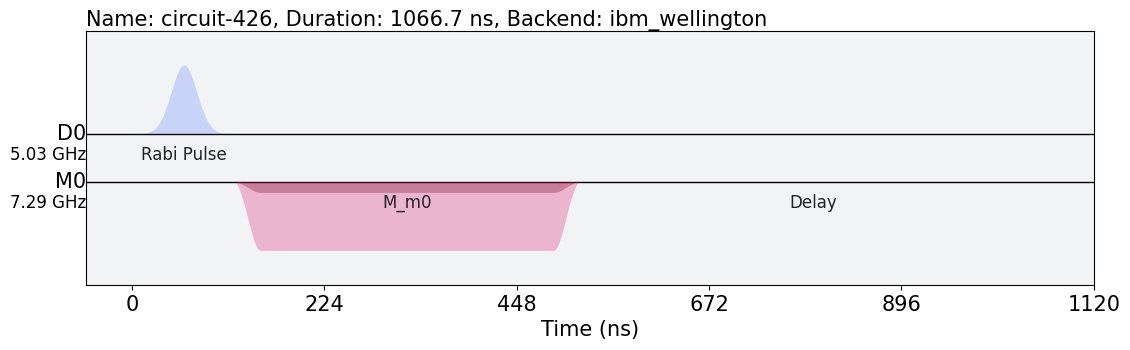

In [36]:
rabi_schedule = schedule(exp_rabi_circs[-1], backend)
rabi_schedule.draw(backend=backend)

In [17]:
num_shots_per_point = 1024

job = backend.run(exp_rabi_circs, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_point)

job_monitor(job)

Job Status: job has successfully run


In [18]:
rabi_results = job.result(timeout=120)

In [17]:
job_id = "6308eeb8bf727df04401267e"
job = provider.get_backend('ibm_wellington').retrieve_job(job_id)
rabi_results = job.result(timeout=120)

In [19]:
# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)

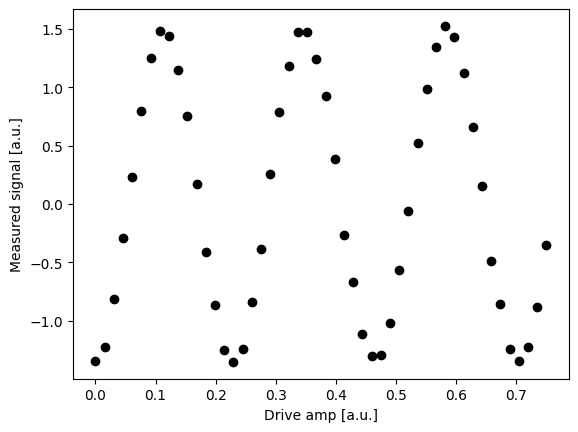

In [20]:
rabi_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[classical_register] * scale_factor)

rabi_values = np.real(baseline_remove(rabi_values))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values, color='black') # plot real part of Rabi values
plt.show()

In [21]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

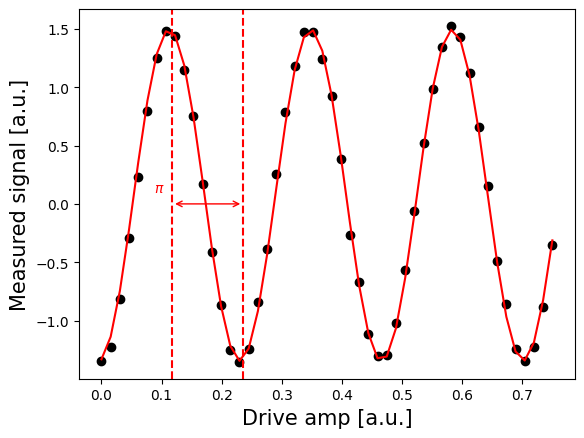

In [22]:
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [3, 0, 0.2, 0])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [23]:
pi_amp_qubit = abs(drive_period / 2)
print(f"Pi Amplitude = {pi_amp_qubit}")

Pi Amplitude = 0.1177715275755729


## $\pi/2$ pulse qubit1 calculation

In [24]:
pi_over_2_amp_qubit = abs(pi_amp_qubit / 2)
print(f"Pi Amplitude = {pi_over_2_amp_qubit}")

Pi Amplitude = 0.05888576378778645


In [25]:
with pulse.build(backend) as pi_over_2_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=pi_over_2_amp_qubit,
                              sigma=drive_sigma,
                              name='pi_over_2_pulse'), drive_chan)

## Spinlocker Test

In [27]:
from spinlocker import T1rho

min_drive_sigma_sec = 0.015 * 1e-6                           
max_drive_sigma_sec = 50 * 1e-6
min_drive_duration_sec = min_drive_sigma_sec * 8
max_drive_duration_sec = max_drive_sigma_sec * 8
durations = np.linspace(min_drive_duration_sec, max_drive_duration_sec, num=50)

In [28]:
exp = T1rho(qubit,
        pi_amp_qubit,
        drive_sigma_sec, # This determines the actual width of the gaussian
        pi_over_2_pulse, # note sure if we pass this in here or if this is the right type
        durations, 
        #pulse.drive_channel(qubit), #not sure i need this
        backend,
    )

In [29]:
exp_data = exp.run(backend=backend).block_for_results()

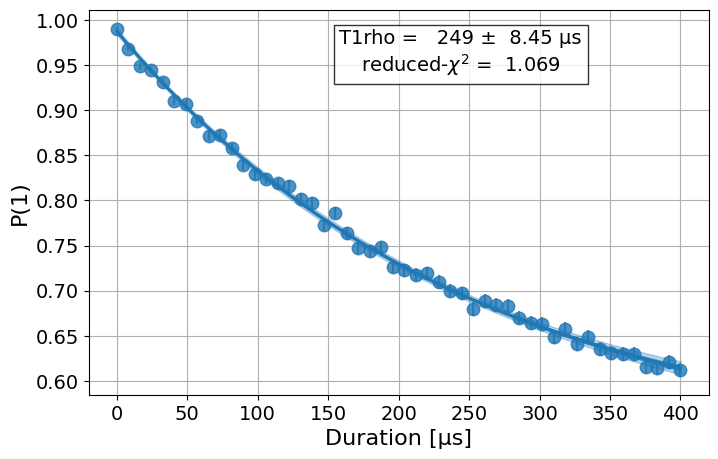

AnalysisResult
- name: @Parameters_T1rhoAnalysis
- value: CurveFitResult:
 - fitting method: least_squares
 - number of sub-models: 1
  * F_exp_decay(x) = amp * exp(-x/tau) + base
 - success: True
 - number of function evals: 17
 - degree of freedom: 47
 - chi-square: 50.24779739332185
 - reduced chi-square: 1.069102072198337
 - Akaike info crit.: 6.2471853790813485
 - Bayesian info crit.: 11.983254395365785
 - init params:
  * amp = 0.37890527368157967
  * tau = 0.0008522679461997549
  * base = 0.6117220694826293
 - fit params:
  * amp = 0.46683998091258355 ± 0.00843923789297527
  * tau = 0.0002487721382204865 ± 8.451891778248029e-06
  * base = 0.5209492501753776 ± 0.00882177209497905
 - correlations:
  * (amp, base) = -0.9908544083220147
  * (tau, base) = -0.9729099167936244
  * (amp, tau) = 0.9479853344033426
- quality: bad
- device_components: ['Q0']
- verified: False
AnalysisResult
- name: T1rho
- value: 0.000249+/-0.000008
- χ²: 1.069102072198337
- quality: bad
- extra: <1 items>

In [30]:
display(exp_data.figure(0))
for result in exp_data.analysis_results():
    print(result)

In [ ]:
# More comprehensive documentation on what I ran, what i found, when we made changes, high level overview of results (things I tried and how far we got)
# okay to include description of early stuff (tried running T2 and T2CPMG but got stuck for reason x...) we should know where all of these threads finished and the errors

In [ ]:
# dont have to do full qiskit experiments test suite becuase this is extension; can push this to public github (and add kevin as collaborator); setup new repository (do with kevin tomorrow morning)